In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import unconstr_solvers as solvers
import step_size as ss
import utils
import scipy.optimize as scopt

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 49.99999999999974


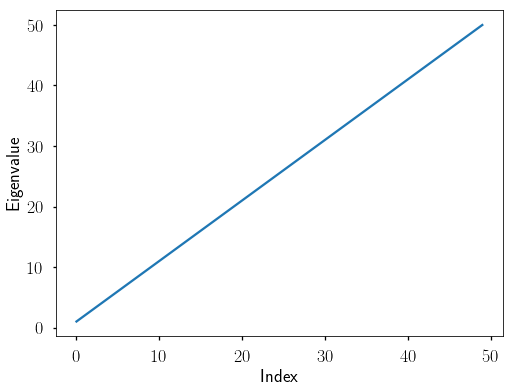

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [4]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [25]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.ConjugateGradientQuad(A, b),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.AcceleratedGD(f, grad_f, 2e-2)
    }

In [26]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [27]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.0355086460130888
Function value = -4.695221641999037
	 Newton
Convergence in 1 iterations
Norm of gradient = 4.4002233435247685e-14
Function value = -4.695513111535449
	 CG quad
Convergence in 37 iterations
Norm of gradient = 3.700240421289733e-07
Function value = -4.695513111535443
	 CG FR
Convergence in 73 iterations
Norm of gradient = 7.276373154688807e-07
Function value = -4.695513111535429
	 BB 1
Convergence in 80 iterations
Norm of gradient = 5.699510049473439e-07
Function value = -4.695513111535302
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 0.012661317070639215
Function value = -4.6954395438079946


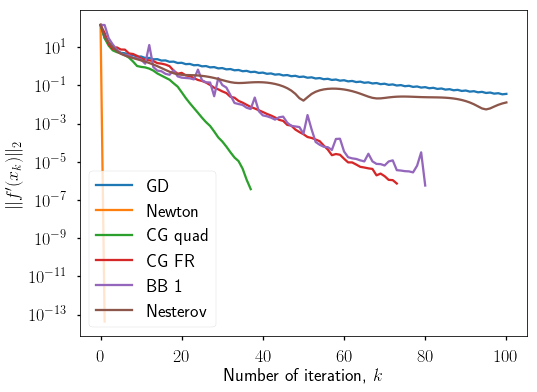

In [28]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=18)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [29]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
1.71 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Newton
59.7 µs ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
710 µs ± 63.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG FR
5.08 ms ± 53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.14 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.29 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000002642


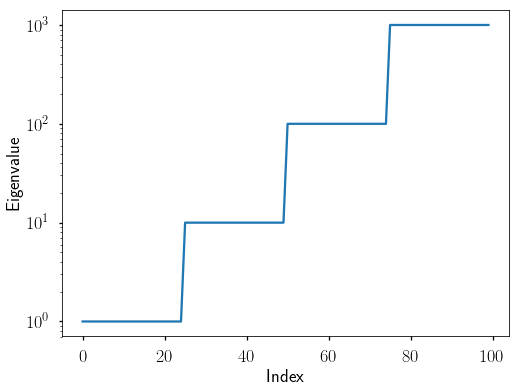

In [30]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [31]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [32]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.ConjugateGradientQuad(A, b),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.AcceleratedGD(f, grad_f, step_size=1e-3)
    }

In [33]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [34]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 11.442316021107123
Function value = -2.9068217786779407
	 Newton
Convergence in 1 iterations
Norm of gradient = 1.054006975823669e-12
Function value = -10.323541259463756
	 CG quad
Convergence in 4 iterations
Norm of gradient = 9.598487020327837e-07
Function value = -10.323541259463589
	 CG FR
Convergence in 100 iterations
Norm of gradient = 0.7601648454330482
Function value = -10.138587072668717
	 BB 1
Convergence in 58 iterations
Norm of gradient = 8.902388347858789e-08
Function value = -10.323541259463886
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 1.028872280968331
Function value = -9.795352685783957


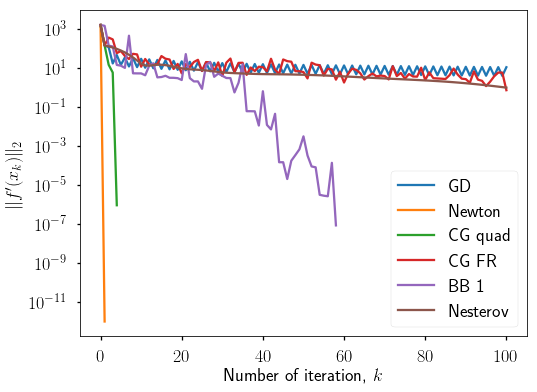

In [35]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [36]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
2.12 ms ± 39.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
124 µs ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
98 µs ± 6.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG FR
16.6 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.13 ms ± 74.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.8 ms ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Analytical center of the set of inequalities

In [37]:
n = 1000
m = 500
A = np.random.rand(n, m) * 10

In [38]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), \
                          axis=1) + 2 * x / (1 - np.power(x, 2))

hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [39]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.AcceleratedGD(f, grad_f, step_size=3e-4)
    }

In [40]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [41]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 25 iterations
Norm of gradient = 7.412179801114641e-06
Function value = -3633.030953356786
	 Newton
Convergence in 14 iterations
Norm of gradient = 1.496144218935319e-08
Function value = -3633.0309533567915
	 CG FR
Convergence in 17 iterations
Norm of gradient = 9.042420103683627e-06
Function value = -3633.030953356784
	 BB 1
Convergence in 9 iterations
Norm of gradient = 6.058390432234223e-06
Function value = -3633.030953356787
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 5.112083006888225
Function value = -3630.945746934998


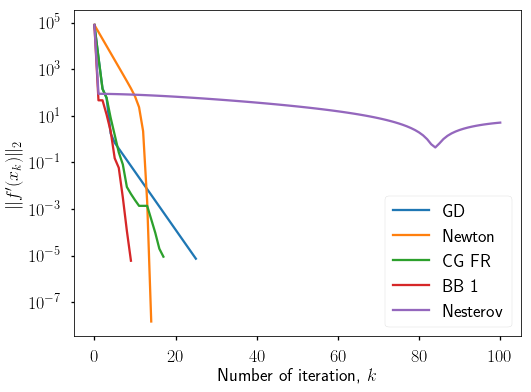

In [42]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [43]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


476 ms ± 70.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Newton
848 ms ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 CG FR


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


351 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 BB 1
100 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Nesterov
989 ms ± 8.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Toy logistic regression with L2 regularization

In [44]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 1.9103116835510103


In [61]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.AcceleratedGD(f, grad_f, step_size=1e-2)
    }

In [62]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [63]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.0006953852270562256
Function value = 0.48494366964229213
	 Newton
Convergence in 36 iterations
Norm of gradient = 8.464322169720381e-06
Function value = 0.4849436276920458
	 CG FR
Convergence in 47 iterations
Norm of gradient = 9.256132649997006e-06
Function value = 0.48494362771452404
	 BB 1
Convergence in 50 iterations
Norm of gradient = 3.624564774656501e-06
Function value = 0.4849436276936413
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 0.0027911826696487957
Function value = 0.48494577425385627


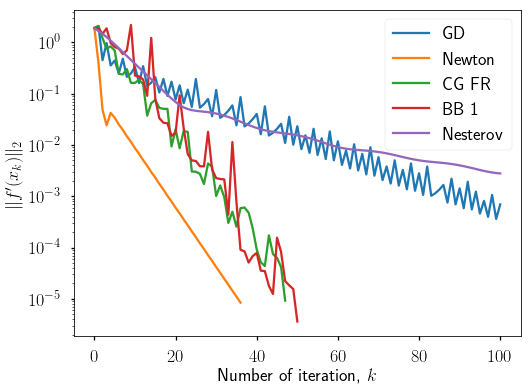

In [64]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [65]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
159 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Newton
170 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 CG FR
69.2 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
13.1 ms ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
25.9 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
